In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, ensemble

plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
# Load Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Get the y values from the training data, drop Id and SalePrice columns
y_train = train_df['SalePrice']
X_train = train_df.drop(['Id', 'SalePrice'], axis=1)

# Drop Id from test, but save for later
test_id = test_df['Id']
X_test = test_df.drop(['Id'], axis=1)

In [3]:
def feature_engineering(df):
    # Let's make a date...column
    date = {'year': df['YrSold'], 'month': df['MoSold'], 'day': [1] * df.shape[0]}
    df['DateSold'] = pd.to_datetime(date)
    df['DateSold'] = (df['DateSold'] - df['DateSold'].min())  / np.timedelta64(1,'D')
    
    # Some features are rankings of the same type
    rank_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

    df['ExterQual'] = df['ExterQual'].map(rank_dict)
    df['ExterCond'] = df['ExterCond'].map(rank_dict)
    df['BsmtQual'] = df['BsmtQual'].map(rank_dict).fillna(0)
    df['BsmtCond'] = df['BsmtCond'].map(rank_dict).fillna(0)
    df['HeatingQC'] = df['HeatingQC'].map(rank_dict).fillna(0)
    df['KitchenQual'] = df['KitchenQual'].map(rank_dict)
    df['FireplaceQu'] = df['FireplaceQu'].map(rank_dict).fillna(0)
    df['GarageQual'] = df['GarageQual'].map(rank_dict).fillna(0)
    df['GarageCond'] = df['GarageCond'].map(rank_dict).fillna(0)
    df['PoolQC'] = df['PoolQC'].map(rank_dict).fillna(0)
    
    # Then there are other features that are really rankings
    df['LotShape'] = df['LotShape'].map({'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3':3})
    df['Utilities'] = df['Utilities'].map({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1})
    df['LandSlope'] = df['LandSlope'].map({'Gtl': 0, 'Mod': 1, 'Sev': 2})
    df['BsmtExposure'] = df['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}).fillna(0)
    df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 
                                                               'LwQ': 2, 'Unf': 1}).fillna(0) 
    df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 
                                                               'LwQ': 2, 'Unf': 1}).fillna(0)
    df['Functional'] = df['Functional'].map({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4,
                                                          'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0})
    df['GarageFinish'] = df['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1}).fillna(0)
    df['Fence'] = df['Fence'].map({'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWv': 1}).fillna(0)
    
    # Fill in None if the NaN value actually means that feature is not present, otherwise the process function
    # will fill in 'U' for truly unknown values later
    df['Alley'] = df['Alley'].fillna('None')
    df['GarageType'] = df['GarageType'].fillna('None')
    df['MiscFeature'] = df['MiscFeature'].fillna('None')
    
    return df

In [4]:
def change_features(X_train, X_test):
    X_train = feature_engineering(X_train)
    X_test = feature_engineering(X_test)
    
    return X_train, X_test

In [5]:
def fill_data(X_train, X_test):   
    # Get lists of continuous and categorical column names
    cont = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
    cat = X_train.select_dtypes(include=['object']).columns.tolist()
    
    # Fill in all the categorical NaN values with 'U' for Unknown
    X_train[cat] = X_train[cat].fillna('U')
    X_test[cat] = X_test[cat].fillna('U')

    # Fill the missing continuous values with the median or a more meaningful value
    X_train[cont] = X_train[cont].fillna(X_train[cont].median())
    X_train['GarageYrBlt'] = X_train['GarageYrBlt'].fillna(X_train['GarageYrBlt'].min())

    # Note that we're filling in the test data with values from the training set
    X_test[cont] = X_test[cont].fillna(X_train[cont].median())
    X_test['GarageYrBlt'] = X_test['GarageYrBlt'].fillna(X_train['GarageYrBlt'].min())
    
    return X_train, X_test

In [6]:
def normalize_features(X_train, X_test):
    # Normalize continuous variables
    skewed = X_train.skew(axis=0, numeric_only=True)
    skewed = skewed[skewed > 1].index.tolist()
    
    nml = preprocessing.Normalizer()
    nml = nml.fit(X_train[skewed])
    
    X_train[skewed] = nml.transform(X_train[skewed])
    X_test[skewed] = nml.transform(X_test[skewed])
    
    return X_train, X_test

In [7]:
def scale_features(X_train, X_test):
    # Get lists of continuous and categorical column names
    cont = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
    
    # Now let's center and scale the continuous variables, fit scaler with training data
    scl = preprocessing.StandardScaler()
    scl = scl.fit(X_train[cont])

    X_train[cont] = scl.transform(X_train[cont])
    X_test[cont] = scl.transform(X_test[cont])
    
    return X_train, X_test

In [8]:
def cat_to_cont(X_train, X_test):
    # Make continuous variables into dummy variables
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # The DataFrame needs to have the same columns as the training data
    diff = list(X_train.columns.difference(X_test.columns))
    X_test = X_test.reindex(columns=list(X_test.columns.values) + diff)
    diff2 = list(X_test.columns.difference(X_train.columns))
    X_test = X_test.drop(diff2, axis=1)
    X_test = X_test.fillna(0)
    
    return X_train, X_test

In [9]:
def normalize_dv(y_train):  
    # Well use the natural log of sale price for our new DV since linear regression assumes normality
    y_train = np.log(y_train)
    
    return y_train

In [10]:
def process_data(X_train, y_train, X_test, feat_eng=False, fill=True,
                 norm_f=False, scale_f=False, c_to_c=True, norm_dv=False):
    if feat_eng == True:
        X_train, X_test = change_features(X_train, X_test)
    
    if fill == True:
        X_train, X_test = fill_data(X_train, X_test)
        
    if norm_f == True:
        X_train, X_test = normalize_features(X_train, X_test)
    
    if scale_f == True:
        X_train, X_test = scale_features(X_train, X_test)
        
    if c_to_c == True:
        X_train, X_test = cat_to_cont(X_train, X_test)
        
    if norm_dv == True:
        y_train = normalize_dv(y_train)
    
    return X_train, y_train, X_test

In [11]:
# You can play with features here
X_train, y_train, X_test = process_data(X_train, y_train, X_test, 
                                              feat_eng=True, norm_f=True, scale_f=True, norm_dv=True)

In [14]:
m = ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=5)
m.fit(X_train, y_train)
pred_y = m.predict(X_test)
prediction = np.exp(pred_y)

Training:
Mean squared error: 0.00
Variance score: 1.00



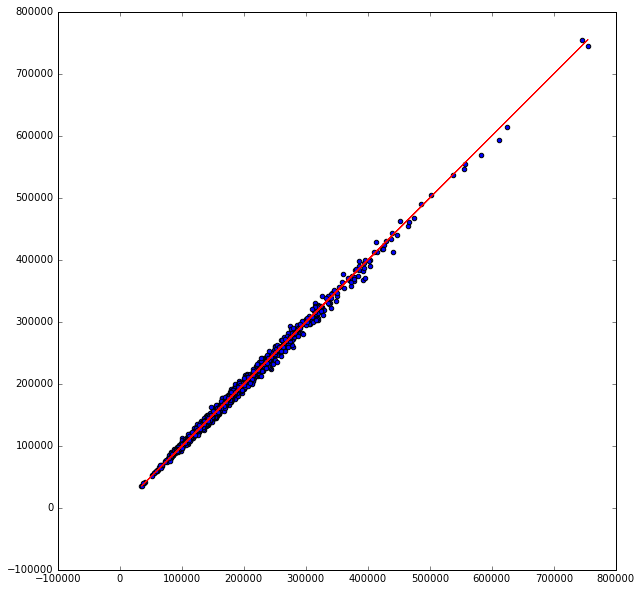

In [18]:
pred_y_train = m.predict(X_train)


print('Training:')
# The mean squared error
print("Mean squared error: %.2f"
    % np.mean((pred_y_train - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % m.score(X_train, y_train))
print('')

actual_train = np.exp(y_train)
predicted_train = np.exp(pred_y_train)
plt.scatter(actual_train, predicted_train)
plt.plot(actual_train, actual_train, 'r')
plt.show()

In [15]:
# DataFrame of Id and Predictions
pred_df = pd.DataFrame(data={'Id': test_id, 'SalePrice': prediction})
pred_df.head()

,Id,SalePrice
0,1461,115484.962517
1,1462,150066.348247
2,1463,164982.266772
3,1464,185525.050732
4,1465,166195.497694


In [16]:
# Save solution file
pred_df.to_csv('solution3.csv', index=False)